# 당뇨병 분류 문제 ( pytorch )

## import Libraries

In [82]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 데이터 전처리 및 스케일링

In [85]:
# 데이터셋 인스턴스 생성
data = pd.read_csv("https://github.com/MyungKyuYi/AI-class/raw/main/diabetes.csv")  # CSV 파일 웹 경로
print(data)
print("\n=====================================================\n")

# 결측치 확인
print(data.isnull().sum())
print("\n=====================================================\n")

# 레이블 불균형 여부를 위한 갯수 확인 (숫자)
print(data['Outcome'].value_counts())
print("\n=====================================================\n")

X = data.drop(['Outcome'], axis=1) # Feature
Y = data['Outcome'] # Label

# Numpy 변환
X = X.values 
Y = Y.values
print(X)
print(Y)

# 데이터 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습 데이터 & 테스트 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=15)

# 분할된 데이터의 shape을 출력
print("\n=====================================================\n")
print("X_train.shape : ", X_train.shape) # (537, 8) : 특성의 개수 8개
print("X_test.shape : ", X_test.shape)
print("Y_train.shape : ", Y_train.shape)
print("Y_test.shape : ", Y_test.shape) 


# numpy 배열 --> torch tensor으로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1) # view(-1, 1) : (행, 1) 형태로 변환. 모델이 기대하는 입력 형태는 2차원 배열이기 때문이다.
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

# torch tensor 데이터의 shape을 출력
print("\n=====================================================\n")
print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("Y_train.shape : ", Y_train.shape)
print("Y_test.shape : ", Y_test.shape)

# PyTorch DataLoader로 감싸서 미니배치 학습 가능하게 함
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # batch size를 32으로 설정
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

## 모델 정의

In [88]:
class Diabetes_Dense(nn.Module):
    def __init__(self):
        super(Diabetes_Dense, self).__init__()
        self.fc1 = nn.Linear(8, 64) # 입력층 : 특성의 개수 8개
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # 출력층 : 이진분류의 출력 뉴런 수는 1
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) # 이진 분류에서 출력층의 활성화 함수는 sigmoid. 만약 BCEWithLogitLoss()를 loss function으로 쓰면 sigmoid 지정 안해도 됨.
        return x

# Initialize the model, loss function, and optimizer
model = Diabetes_Dense() # 모델 생성
criterion = nn.BCELoss() # 손실 함수. 이진분류이므로 BCELoss() 사용.
optimizer = optim.Adam(model.parameters(), lr=0.001) # 옵티마이저는 Adam을 사용


## 모델 학습

In [91]:
# Variables to store loss and accuracy
train_losses = [] # 각 epoch마다 평균 loss를 저장할 리스트
test_accuracies = [] # 각 epoch마다 accuracy를 저장할 리스트

# Training loop
num_epochs = 20
for epoch in range(num_epochs): # epoch(20) 동안 훈련
    model.train() # 학습 모드
    running_loss = 0.0 # 해당 epoch의 loss의 초기값을 0으로 설정
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs) # inputs(특성들)을 모델에 입력하여 예측. outputs : 모델의 예측값(분류이므로 각 클래스에 대한 확률값)
        loss = criterion(outputs, labels) # 예측값과 실제 label값들을 매치시켜 loss를 계산.

        # Backward pass and optimize
        loss.backward() # 역방향 전파. 가중치와 편향을 조정하는 과정
        optimizer.step()

        running_loss += loss.item() # 해당 epoch의 총 loss값

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader)) # epoch마다 평균 loss값을 저장. 한 epoch에서 나온 총 loss를 배치(batch) 수로 나눠서 평균을 구해 기록하는 줄.

    # Evaluate on test data
    model.eval() # 평가 모드
    correct = 0 # 예측 성공 수
    total = 0 # 샘플 수
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs) # 예측
            predicted = (outputs >= 0.5).float()  # 0.5 기준으로 0, 1 분류
            total += labels.size(0) # 전체 샘플 수 누적
            correct += (predicted == labels).sum().item() # 예측이 맞았으면, 예측 성공 수 증가

    accuracy = 100 * correct / total # accuracy : 맞춘 샘플 수 / 전체 샘플 수
    test_accuracies.append(accuracy) # epoch마다 정확도 값을 저장

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%") # epoch마다 평균 loss와 정확도를 출력

print("Training complete.")

Epoch 1/20, Loss: 0.6739, Accuracy: 74.46%
Epoch 2/20, Loss: 0.6252, Accuracy: 76.19%
Epoch 3/20, Loss: 0.5731, Accuracy: 76.19%
Epoch 4/20, Loss: 0.5232, Accuracy: 76.19%
Epoch 5/20, Loss: 0.4852, Accuracy: 77.06%
Epoch 6/20, Loss: 0.4614, Accuracy: 77.49%
Epoch 7/20, Loss: 0.4469, Accuracy: 77.49%
Epoch 8/20, Loss: 0.4400, Accuracy: 77.06%
Epoch 9/20, Loss: 0.4364, Accuracy: 77.92%
Epoch 10/20, Loss: 0.4308, Accuracy: 77.92%
Epoch 11/20, Loss: 0.4299, Accuracy: 76.19%
Epoch 12/20, Loss: 0.4252, Accuracy: 77.92%
Epoch 13/20, Loss: 0.4254, Accuracy: 77.49%
Epoch 14/20, Loss: 0.4253, Accuracy: 77.49%
Epoch 15/20, Loss: 0.4171, Accuracy: 77.06%
Epoch 16/20, Loss: 0.4177, Accuracy: 77.49%
Epoch 17/20, Loss: 0.4179, Accuracy: 77.49%
Epoch 18/20, Loss: 0.4156, Accuracy: 77.49%
Epoch 19/20, Loss: 0.4129, Accuracy: 77.49%
Epoch 20/20, Loss: 0.4111, Accuracy: 77.06%
Training complete.


## 모델 평가



Confusion Matrix:
[[132  28]
 [ 25  46]]


F1 Score: 0.77


Precision: 0.77


Recall: 0.77


Specificity: 0.74




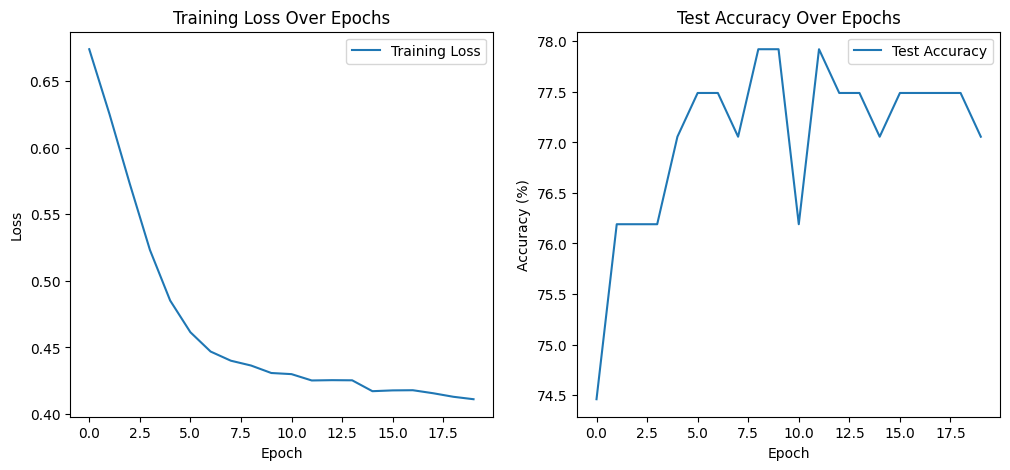

In [94]:
# Evaluation
model.eval() # 평가 모드
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs) # 예측
        predicted = (outputs >= 0.5).float()  # 0.5 기준으로 0, 1 분류
        all_labels.extend(labels.cpu().numpy()) # all_labels 리스트에 실제 값을 저장
        all_predictions.extend(predicted.cpu().numpy()) # all_predictions 리스트에 예측 값을 저장

# numpy 배열로 변환
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 실제 값과 예측 값을 매치하여 혼동 행렬, f1-score, precision, recall을 계산.
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# 각 클래스에 대한 특이도(specificity) 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

# 위에서 계산한 평가 지표들을 출력.
print("\n=====================================================\n")
print(f'Confusion Matrix:\n{conf_matrix}')
print("\n=====================================================\n")
print(f'F1 Score: {f1:.2f}')
print("\n=====================================================\n")
print(f'Precision: {precision:.2f}')
print("\n=====================================================\n")
print(f'Recall: {recall:.2f}')
print("\n=====================================================\n")
print(f'Specificity: {np.mean(specificity):.2f}')
print("\n=====================================================\n")


# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# 학습이 진행됨에 따라 변화하는 loss 값을 시각화
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 학습이 진행됨에 따라 변화하는 accuracy 값을 시각화
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()